In [2]:
# ==========================
# 1. Φόρτωση και Προετοιμασία Δεδομένων
# ==========================

import pandas as pd
import numpy as np

# Φόρτωση δεδομένων από CSV
data = pd.read_csv('C:\\Machine_Learning_Assignment\\output_features\\visible_hog_feature.csv')  # Αντικατάστησε με τη διαδρομή του αρχείου σου

# Διαχωρισμός χαρακτηριστικών (X) και ετικετών (y)
X = data.iloc[:, :-1]  # Όλες οι στήλες εκτός της τελευταίας
y = data.iloc[:, -1]   # Τελευταία στήλη (labels)

# Εμφάνιση διαστάσεων και κατανομή των ετικετών
print(f"Χαρακτηριστικά: {X.shape}, Ετικέτες: {y.shape}")
print("\n🔹 Κατανομή Δεδομένων ανά Κατηγορία:")
print(y.value_counts())

Χαρακτηριστικά: (24613, 3780), Ετικέτες: (24613,)

🔹 Κατανομή Δεδομένων ανά Κατηγορία:
class
Car           19451
Pedestrian     3669
Cyclist        1204
Tram            289
Name: count, dtype: int64


In [4]:
# ==========================
# 2. Διαχωρισμός σε Train - Validation - Test Set
# ==========================

from sklearn.model_selection import train_test_split

# Αρχικός διαχωρισμός: 80% (train+validation) και 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Από τα 80%, επιλέγουμε 20% ως validation (δηλαδή περίπου 16% του συνόλου) και 80% ως train (περίπου 64% του συνόλου)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print(f"\nΜέγεθος Train Set: {X_train.shape}")
print(f"Μέγεθος Validation Set: {X_val.shape}")
print(f"Μέγεθος Test Set: {X_test.shape}")


Μέγεθος Train Set: (15752, 3780)
Μέγεθος Validation Set: (3938, 3780)
Μέγεθος Test Set: (4923, 3780)


In [6]:
# ==========================
# 3. Scaling (Κλιμάκωση) και PCA (Μείωση Διαστάσεων)
# ==========================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Κλιμάκωση: Εφαρμογή fit στο train και transform στα υπόλοιπα set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nΚλιμάκωση ολοκληρώθηκε.")

# PCA: Εφαρμογή PCA με διατήρηση του 95% της μεταβλητότητας (εδώ ορίζουμε 300 συνιστώσες)
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nΔιαστάσεις μετά το PCA (Train): {X_train_pca.shape}")


Κλιμάκωση ολοκληρώθηκε.

Διαστάσεις μετά το PCA (Train): (15752, 300)


In [8]:
# ==========================
# 4. Τυχαία Επιλογή Υποσυνόλου & Εξισορρόπηση με SMOTE (μόνο στο Train set)
# ==========================

from imblearn.over_sampling import SMOTE

# Επαναφορά των indices για το train set
y_train_reset = y_train.reset_index(drop=True)
X_train_pca_reset = X_train_pca  # Είναι NumPy array

# 🔹 Downsampling για 'Car'
car_indices = np.where(y_train_reset == 'Car')[0]  # Δείκτες των 'Car'
selected_car_indices = np.random.choice(car_indices, 3500, replace=False)  # Επιλογή τυχαίων 2935 'Car'
# 🔹 Κρατάμε όλα τα υπόλοιπα labels
non_car_indices = np.where(y_train_reset != 'Car')[0]
selected_indices = np.concatenate([selected_car_indices, non_car_indices])

# Δημιουργία νέου balanced set
X_train_balanced = X_train_pca_reset[selected_indices]
y_train_balanced = y_train_reset.iloc[selected_indices].values  # Μετατροπή σε NumPy array

# 🔹 Εφαρμογή SMOTE για αύξηση των κατηγοριών 'Cyclist' & 'Tram'
smote = SMOTE(sampling_strategy={'Cyclist': 3500, 'Tram': 3500}, random_state=42)
X_train_final, y_train_final = smote.fit_resample(X_train_balanced, y_train_balanced)

print(f"\nΤελικό μέγεθος μετά το downsampling & SMOTE (Train): {X_train_final.shape}, {y_train_final.shape}")
print("\n🔹 Νέα Κατανομή Δεδομένων στο Train Set:")
print(pd.Series(y_train_final).value_counts())


Τελικό μέγεθος μετά το downsampling & SMOTE (Train): (12848, 300), (12848,)

🔹 Νέα Κατανομή Δεδομένων στο Train Set:
Car           3500
Cyclist       3500
Tram          3500
Pedestrian    2348
Name: count, dtype: int64


C:\Users\irakl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\irakl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [10]:
# ==========================
# 5. K-Fold Cross-Validation & Grid Search για διάφορες τιμές n_estimators (με Macro F1-score)
# ==========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

n_estimators_list = [100, 150, 200, 250, 300]  # Λίστα τιμών για το n_estimators
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

cv_results = {}

print("\nΚ-Fold Cross-Validation για διάφορες τιμές n_estimators (με Macro F1-score):")
for n in n_estimators_list:
    macro_f1_scores = []
    for train_index, val_index in kf.split(X_train_final):
        X_train_fold, X_val_fold = X_train_final[train_index], X_train_final[val_index]
        y_train_fold, y_val_fold = y_train_final[train_index], y_train_final[val_index]
        
        # Αρχικοποίηση και εκπαίδευση του Random Forest για την τρέχουσα τιμή του n_estimators
        model_temp = RandomForestClassifier(n_estimators=n, random_state=42)
        model_temp.fit(X_train_fold, y_train_fold)
        
        # Πρόβλεψη στο validation fold
        y_val_pred = model_temp.predict(X_val_fold)
        macro_f1 = f1_score(y_val_fold, y_val_pred, average='macro')
        macro_f1_scores.append(macro_f1)
    
    mean_f1 = np.mean(macro_f1_scores)
    std_f1 = np.std(macro_f1_scores)
    cv_results[n] = (mean_f1, std_f1)
    print(f"n_estimators: {n} -> Macro F1: {mean_f1:.4f} (std: {std_f1:.4f})")




Κ-Fold Cross-Validation για διάφορες τιμές n_estimators (με Macro F1-score):
n_estimators: 100 -> Macro F1: 0.9751 (std: 0.0044)
n_estimators: 150 -> Macro F1: 0.9778 (std: 0.0038)
n_estimators: 200 -> Macro F1: 0.9794 (std: 0.0029)
n_estimators: 250 -> Macro F1: 0.9803 (std: 0.0027)
n_estimators: 300 -> Macro F1: 0.9809 (std: 0.0033)

Επιλέχθηκε το n_estimators = 300 ως καλύτερη τιμή.


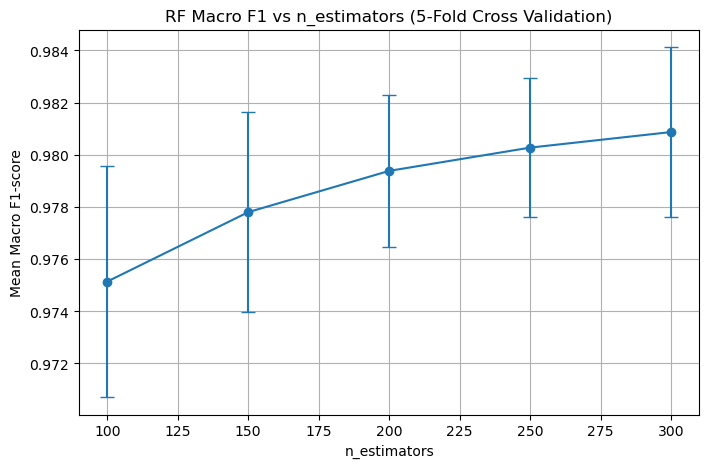

In [38]:
import matplotlib.pyplot as plt

# Εξαγωγή των τιμών από το λεξικό cv_results
n_values = sorted(cv_results.keys())
mean_f1_values = [cv_results[n][0] for n in n_values]
std_f1_values = [cv_results[n][1] for n in n_values]

# Δημιουργία διαγράμματος με error bars
plt.figure(figsize=(8, 5))
plt.errorbar(n_values, mean_f1_values, yerr=std_f1_values, fmt='o-', capsize=5)
plt.xlabel('n_estimators')
plt.ylabel('Mean Macro F1-score')
plt.title('RF Macro F1 vs n_estimators (5-Fold Cross Validation)')
plt.grid(True)
plt.show()

In [18]:
# ==========================
# K-Fold Cross-Validation στο Αρχικό (Unbalanced) Training Set (χωρίς SMOTE και Undersampling)
# ==========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Επαναφορά των indices για το αρχικό training set 
y_train_unbalanced = y_train.reset_index(drop=True)
X_train_unbalanced = X_train_pca  # X_train_pca είναι ήδη το PCA-transformed training set

# Ορισμός τιμών για το n_estimators που θα δοκιμάσουμε
n_estimators_list = [100, 150, 200, 250, 300]
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

cv_results_unbalanced = {}

print("\nK-Fold Cross-Validation στο αρχικό (unbalanced) Training Set (χωρίς SMOTE/Undersampling):")
for n in n_estimators_list:
    macro_f1_scores = []
    # Διαιρούμε τα δεδομένα σε 5 folds
    for train_index, val_index in kf.split(X_train_unbalanced):
        X_train_fold, X_val_fold = X_train_unbalanced[train_index], X_train_unbalanced[val_index]
        y_train_fold, y_val_fold = y_train_unbalanced.iloc[train_index], y_train_unbalanced.iloc[val_index]
        
        # Εκπαίδευση του μοντέλου με την τρέχουσα τιμή του n_estimators
        model_temp = RandomForestClassifier(n_estimators=n, random_state=42)
        model_temp.fit(X_train_fold, y_train_fold)
        
        # Πρόβλεψη στο validation fold και υπολογισμός του Macro F1-score
        y_val_pred = model_temp.predict(X_val_fold)
        macro_f1 = f1_score(y_val_fold, y_val_pred, average='macro')
        macro_f1_scores.append(macro_f1)
    
    mean_f1 = np.mean(macro_f1_scores)
    std_f1 = np.std(macro_f1_scores)
    cv_results_unbalanced[n] = (mean_f1, std_f1)
    print(f"n_estimators: {n} -> Macro F1: {mean_f1:.4f} (std: {std_f1:.4f})")



K-Fold Cross-Validation στο αρχικό (unbalanced) Training Set (χωρίς SMOTE/Undersampling):
n_estimators: 100 -> Macro F1: 0.5484 (std: 0.0185)
n_estimators: 150 -> Macro F1: 0.5379 (std: 0.0119)
n_estimators: 200 -> Macro F1: 0.5433 (std: 0.0134)
n_estimators: 250 -> Macro F1: 0.5432 (std: 0.0155)
n_estimators: 300 -> Macro F1: 0.5447 (std: 0.0152)

Επιλέχθηκε το n_estimators = 100 ως καλύτερη τιμή στο unbalanced training set.


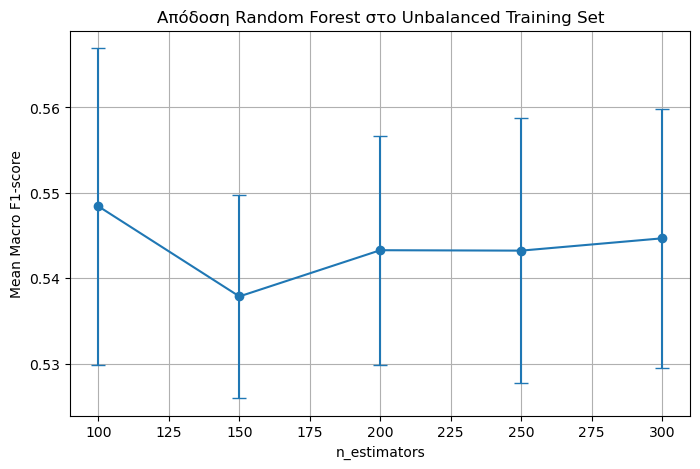

In [40]:
import matplotlib.pyplot as plt

# Εξαγωγή των τιμών από το λεξικό cv_results_unbalanced
n_values = sorted(cv_results_unbalanced.keys())
mean_f1_values = [cv_results_unbalanced[n][0] for n in n_values]
std_f1_values = [cv_results_unbalanced[n][1] for n in n_values]

# Δημιουργία διαγράμματος με error bars
plt.figure(figsize=(8, 5))
plt.errorbar(n_values, mean_f1_values, yerr=std_f1_values, fmt='o-', capsize=5)
plt.xlabel('n_estimators')
plt.ylabel('Mean Macro F1-score')
plt.title('Απόδοση Random Forest στο Unbalanced Training Set')
plt.grid(True)
plt.show()


In [50]:
# ==========================
# 6. Τελική Εκπαίδευση & Αξιολόγηση του Μοντέλου
# ==========================

from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Εκπαίδευση του τελικού μοντέλου στο (balanced) Train set χρησιμοποιώντας το καλύτερο n_estimators
model_final = RandomForestClassifier(n_estimators=300, random_state=42)
model_final.fit(X_train_final, y_train_final)

# Τελική αξιολόγηση στο Test Set
y_test_pred = model_final.predict(X_test_pca)

print("\n🔹 Classification Report στο Test Set:")
print(classification_report(y_test, y_test_pred))

macro_f1_test = f1_score(y_test, y_test_pred, average='macro')
print(f"\n🔹 Macro F1-score στο Test Set: {macro_f1_test:.4f}")

cm = confusion_matrix(y_test, y_test_pred)
print("\n🔹 Confusion Matrix στο Test Set:")
print(cm)


🔹 Classification Report στο Test Set:
              precision    recall  f1-score   support

         Car       0.98      1.00      0.99      3890
     Cyclist       0.94      0.68      0.79       241
  Pedestrian       0.90      0.95      0.93       734
        Tram       1.00      0.79      0.88        58

    accuracy                           0.97      4923
   macro avg       0.96      0.86      0.90      4923
weighted avg       0.97      0.97      0.97      4923


🔹 Macro F1-score στο Test Set: 0.8984

🔹 Confusion Matrix στο Test Set:
[[3873    2   15    0]
 [  17  165   59    0]
 [  30    8  696    0]
 [  12    0    0   46]]


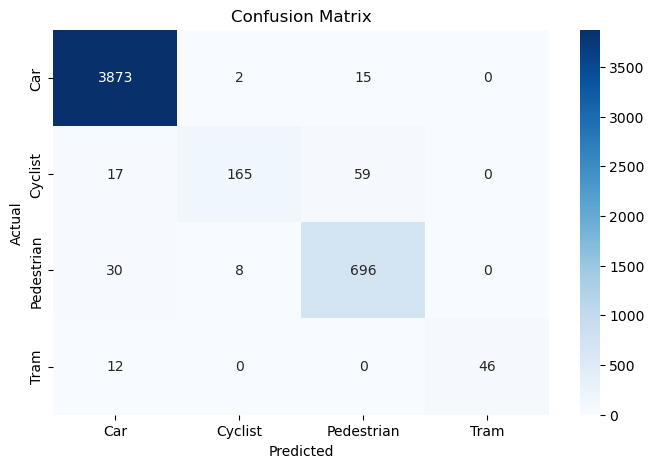

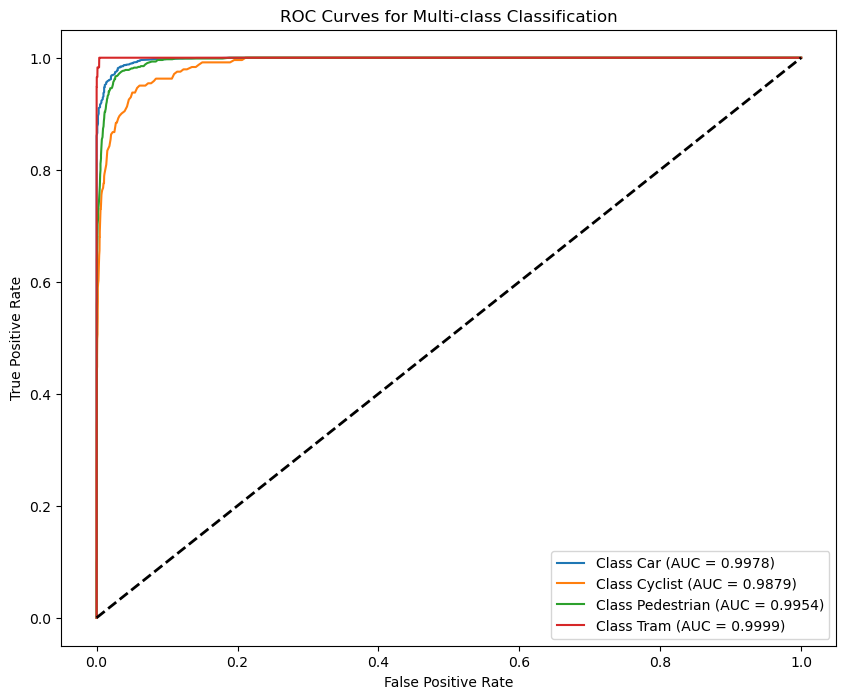

In [56]:
# ==========================
# 7. Οπτικοποίηση των Αποτελεσμάτων
# ==========================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 7.1. Confusion Matrix
labels = model_final.classes_  # Τα labels του μοντέλου

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 7.2. ROC Curves για κάθε κατηγορία
# Για αυτό απαιτείται το predict_proba
y_test_proba = model_final.predict_proba(X_test_pca)
n_classes = len(labels)

plt.figure(figsize=(10,8))
for i in range(n_classes):
    # Μετατρέπουμε τις ετικέτες σε δυαδική μορφή για την κάθε κατηγορία
    fpr, tpr, _ = roc_curve((y_test == labels[i]).astype(int), y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {labels[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-class Classification")
plt.legend(loc="lower right")
plt.show()

C:\Users\irakl\AppData\Local\Temp\ipykernel_27980\728284485.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette="Blues")


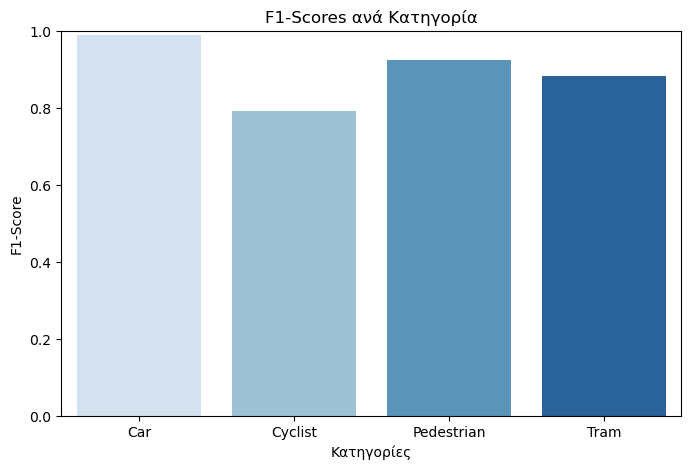

In [32]:
# 7.3. Οπτικοποίηση F1-Scores ανά κατηγορία
report = classification_report(y_test, y_test_pred, output_dict=True)
f1_scores = [report[label]["f1-score"] for label in labels]

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=f1_scores, palette="Blues")
plt.xlabel("Κατηγορίες")
plt.ylabel("F1-Score")
plt.title("F1-Scores ανά Κατηγορία")
plt.ylim(0, 1)
plt.show()